In [1]:
import pandas as pd
import numpy as np
from pandas.io.html import read_html
page = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

<h2>1. Scraping the Wikipedia page to get the postal codes of Canada

In [2]:
tables_from_page = read_html(page, attrs = {'class':'wikitable'})
# The table will be in "tables_from_page" as an array. If there were more than one table in the page 
# they will be under the coreresponding index in the array
# Because it is only one. It is in the index 0.

To get the class name(wikitable):
Right click on webpage (better over the table), Click on "Inspect" option, then look for "Table class=" on inspect window.

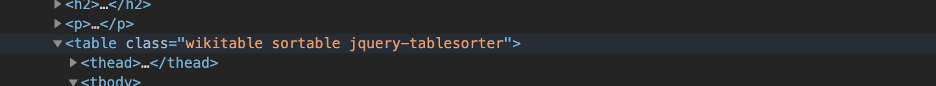

In [3]:
# When the table it is assigned, the final format is a dataframe
df = tables_from_page[0]
df

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
...,...,...,...
175,M5Z,Not assigned,Not assigned
176,M6Z,Not assigned,Not assigned
177,M7Z,Not assigned,Not assigned
178,M8Z,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,..."


In [4]:
# Clean up the dataframe from all Borough equals "Not assigned"  
df=df[df['Borough']!='Not assigned']
df.head()

,Postal Code,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


<h3> The table extracted comes with neighborhoods already combined into one row, so, I separated them to make the instruction about combining the neighborhoods makes sense.

In [5]:
# df['Neighborhood'].str.split(', ',expand=True) # Create one column for every combined neighborhood in the row and
# let it know how many columns should be add to the dataframe 

# After knowing how many columns should be add, the originale dataframe should be reestablished and
# then to add the columns with separated neighborhoods on each.
df[['Ne0','Ne1','Ne2','Ne3','Ne4','Ne5','Ne6','Ne7']] = df['Neighbourhood'].str.split(', ',expand=True)

# Transpose columns to rows.  
df = df.set_index(['Postal Code','Borough']).stack().reset_index()

# Transpose creates a column called "level_2" with the name of columns (this is the stacker columns),
#and a column 0 with the name of neighborhoods rename both columns
df.rename(columns={'Postal Code':'PostalCode',0:'Neighborhoods'},inplace=True)

# Drop rows with original neighborhoods combined, because they already are separated.  
df = df.drop(index=df[df['level_2'] == 'Neighbourhood'].index)

# Drop the columns with columns names. Only the column with neighborhoods names is useful. 
df.drop(columns='level_2',inplace=True)

# Dataframe with neighborhoods separated
df.head()

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,PostalCode,Borough,Neighborhoods
1,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,Regent Park
6,M5A,Downtown Toronto,Harbourfront
8,M6A,North York,Lawrence Manor


In [6]:
# Grouping neighbourhoods with same PostalCode
df = df.groupby(['PostalCode','Borough'], sort=False).agg(', '.join)
df.reset_index(inplace=True)
print(df.shape)
df.head()

(103, 3)


,PostalCode,Borough,Neighborhoods
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [7]:
df.shape

(103, 3)

<h2>2. Getting coordinates of neighborhoods in Canada and mergeing them to the Postal code dataframe

<h3>Importing csv file with coodinates

In [8]:
df_lat_lng = pd.read_csv('http://cocl.us/Geospatial_data')
df_lat_lng.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [9]:
# Eliminate spaces in column name
df_lat_lng.rename(columns={'Postal Code':'PostalCode'},inplace=True)

In [10]:
#Mergin both dataframe
df_geo_merge = pd.merge(df_lat_lng, df, on='PostalCode')
df_geo_merge.head()

,PostalCode,Latitude,Longitude,Borough,Neighborhoods
0,M1B,43.806686,-79.194353,Scarborough,"Malvern, Rouge"
1,M1C,43.784535,-79.160497,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,43.763573,-79.188711,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,43.770992,-79.216917,Scarborough,Woburn
4,M1H,43.773136,-79.239476,Scarborough,Cedarbrae


<h3>Reordering columns

In [11]:
# inplace=True doesn't work, so it should be assigned to a new dataframe or the sameone
df_geo_merge = df_geo_merge[['PostalCode','Borough','Neighborhoods','Latitude','Longitude']]

In [12]:
df_geo_merge.head()

,PostalCode,Borough,Neighborhoods,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


<h2>3. Selecting data only from Toronto. Maps to visualize neighborhoods. Segmentation by distance

In [13]:
# df_toronto=df_geo_merge[df_geo_merge['Borough'].str.contains("Toronto")] # Select Toronto rows,
# but preserve the original index, so start with index 37

# df_toronto=df_geo_merge[df_geo_merge['Borough'].str.contains("Toronto")].reset_index() # Reset index from 0,
# but add a column "index" with original indexes.

# setting PostCode as index eliminate the columm "index", and then resetting index start index from 0
df_toronto = df_geo_merge[df_geo_merge['Borough'].str.contains("Toronto")].set_index('PostalCode').reset_index()

print(df_toronto.shape)

df_toronto.head()

(39, 5)


,PostalCode,Borough,Neighborhoods,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


<h3> adress correspond to neighborhood in third row (index 2) in "df_toronto"

In [14]:
CLIENT_ID = 'CYOZ4YP53MYMNGMXDUTPEQNCA1XXBDOC1DXYMF13HHO3DQDQ' # your Foursquare ID
CLIENT_SECRET = 'SN3DFCYX31PF4JCF0G3OTEZM5I3CTX2GURDSPM0P3Z4XGU0Y' # your Foursquare Secret
ACCESS_TOKEN = 'TOHLJH4GJCHQUCS4KXJ3N5GXNBVOJ0UF0GVUVSN5ZVCQKNW3' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 500

In [15]:
#!pip install geopy
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

address = '1973 Dundas Street East, Old Toronto, ON M4L 3B3, Canada'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

43.668899853846156 -79.3155706846154


<h3> Parks around coordinates 43.668999	-79.315572 (third row in dataframe)

In [16]:
search_query = 'Park'
radius = 1500
print(search_query + ' .... OK!')

Park .... OK!


In [17]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude,ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)
url


'https://api.foursquare.com/v2/venues/search?client_id=CYOZ4YP53MYMNGMXDUTPEQNCA1XXBDOC1DXYMF13HHO3DQDQ&client_secret=SN3DFCYX31PF4JCF0G3OTEZM5I3CTX2GURDSPM0P3Z4XGU0Y&ll=43.668899853846156,-79.3155706846154&oauth_token=TOHLJH4GJCHQUCS4KXJ3N5GXNBVOJ0UF0GVUVSN5ZVCQKNW3&v=20180604&query=Park&radius=1500&limit=500'

In [18]:
# Getting the information in url and transforming to a JSON format
import requests # library to handle requests
from pandas.io.json import json_normalize
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '600f773bdd4ff939fa877c76'},
 'notifications': [{'type': 'notificationTray', 'item': {'unreadCount': 0}}],
 'response': {'venues': [{'id': '4baa029cf964a52085433ae3',
    'name': 'Woodbine Park',
    'location': {'address': 'Queen St',
     'crossStreet': 'at Kingston Rd',
     'lat': 43.66486036311473,
     'lng': -79.31510925292969,
     'labeledLatLngs': [{'label': 'display',
       'lat': 43.66486036311473,
       'lng': -79.31510925292969}],
     'distance': 451,
     'postalCode': 'M4L 1G7',
     'cc': 'CA',
     'city': 'Toronto',
     'state': 'ON',
     'country': 'Canada',
     'formattedAddress': ['Queen St (at Kingston Rd)',
      'Toronto ON M4L 1G7',
      'Canada']},
    'categories': [{'id': '4bf58dd8d48988d163941735',
      'name': 'Park',
      'pluralName': 'Parks',
      'shortName': 'Park',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/park_',
       'suffix': '.png'},
      'primary': True}],
  

In [19]:
# assign information about every element in JSON to venues:
# 'id': '4baa029cf964a52085433ae3','name': 'Woodbine Park',.....
# 'id': '4b8afc59f964a520b78c32e3','name': 'Orchard Park',.....
# 'id': '4e08809f6284d9ee92db9158','name': 'Park discount'.....
# etc., to generate a dataframe

venues = results['response']['venues']

# tranform venues into a dataframe
df_results = pd.json_normalize(venues)
df_results.head()

,id,name,categories,referralId,hasPerk,location.address,location.crossStreet,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,location.neighborhood
0,4baa029cf964a52085433ae3,Woodbine Park,"[{'id': '4bf58dd8d48988d163941735', 'name': 'P...",v-1611626300,False,Queen St,at Kingston Rd,43.664860,-79.315109,"[{'label': 'display', 'lat': 43.66486036311473...",451,M4L 1G7,CA,Toronto,ON,Canada,"[Queen St (at Kingston Rd), Toronto ON M4L 1G7...",NaN
1,4afef402f964a520103222e3,Monarch Park,"[{'id': '4bf58dd8d48988d163941735', 'name': 'P...",v-1611626300,False,115 Felstead Ave,Monarch Park,43.678719,-79.325957,"[{'label': 'display', 'lat': 43.67871904254988...",1376,NaN,CA,Toronto,ON,Canada,"[115 Felstead Ave (Monarch Park), Toronto ON, ...",NaN
2,50a01c82e4b0a0263fcfdcb9,Monarch Park Stadium,"[{'id': '4cce455aebf7b749d5e191f5', 'name': 'S...",v-1611626300,False,115 Felstead Ave,NaN,43.678144,-79.324038,"[{'label': 'display', 'lat': 43.6781436961028,...",1234,NaN,CA,Toronto,ON,Canada,"[115 Felstead Ave, Toronto ON, Canada]",NaN
3,4b8afc59f964a520b78c32e3,Orchard Park,"[{'id': '4bf58dd8d48988d163941735', 'name': 'P...",v-1611626300,False,NaN,NaN,43.668858,-79.314160,"[{'label': 'display', 'lat': 43.66885831178212...",113,NaN,CA,NaN,NaN,Canada,[Canada],NaN
4,4e08809f6284d9ee92db9158,Park discount,"[{'id': '4d954b0ea243a5684a65b473', 'name': 'C...",v-1611626300,False,1612 Queen St E,NaN,43.666422,-79.316466,"[{'label': 'display', 'lat': 43.66642169787026...",285,NaN,CA,Toronto,ON,Canada,"[1612 Queen St E, Toronto ON, Canada]",NaN


In [20]:
# keeping some columns included venue
select_columns = ['name', 'categories'] + ['location.lat', 'location.lng', 'location.distance' ,'id']
df_col_selected = df_results.loc[:, select_columns]

# function that extracts the name of category of the venue from the JSON
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# assign the name of category exteracted by the function to the column "category"
df_col_selected['categories'] = df_col_selected.apply(get_category_type, axis=1)

# clean column names by keeping only last term, and dropping "location."
df_col_selected.columns = [column.split('.')[-1] for column in df_col_selected.columns]

df_col_selected

,name,categories,lat,lng,distance,id
0,Woodbine Park,Park,43.664860,-79.315109,451,4baa029cf964a52085433ae3
1,Monarch Park,Park,43.678719,-79.325957,1376,4afef402f964a520103222e3
2,Monarch Park Stadium,Soccer Field,43.678144,-79.324038,1234,50a01c82e4b0a0263fcfdcb9
3,Orchard Park,Park,43.668858,-79.314160,113,4b8afc59f964a520b78c32e3
4,Park discount,Convenience Store,43.666422,-79.316466,285,4e08809f6284d9ee92db9158
5,Fairmount Park,Baseball Field,43.675286,-79.315745,711,4c48fc9a1b430f47d190e9c2
6,Jonathan Ashbridge Park,Park,43.664702,-79.319898,582,4d0cef321f6bf04d75707a31
7,Measurement Park,Park,43.666916,-79.312631,323,4ba2112ef964a52068d937e3
8,BCSL Woodbine Park Soccer Field,Soccer Field,43.666359,-79.311877,410,4c23e9adf1272d7f113a82c5
9,Dundas Park,None,43.667435,-79.310636,429,4c8548a6d92ea093378a6472


In [21]:
#! pip install folium==0.5.0
import folium # plotting library
venues_map = folium.Map(location=[latitude, longitude], zoom_start=14) # generate map centred around the 1973 Dundas Street East

lat_str = str(float("{:.4f}".format(latitude)))
lng_str = str(float("{:.4f}".format(longitude)))

# add a red circle marker to represent the 1973 Dundas Street East
folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup = '1973 Dundas Street East (' + lat_str + ',' + lng_str + ')',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# Parks as blue circle markers
for lat, lng, label in zip(df_col_selected.lat, df_col_selected.lng, df_col_selected.categories):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map

<h3>Pre-procesing: For Distance Segmentation

In [22]:
# Drop categorical variable in dataset
df = df_col_selected.drop(['name','categories','id'], axis=1)
df.head()

,lat,lng,distance
0,43.664860,-79.315109,451
1,43.678719,-79.325957,1376
2,43.678144,-79.324038,1234
3,43.668858,-79.314160,113
4,43.666422,-79.316466,285


<b>Normalization of lat, lng and distance.

In [23]:
from sklearn.preprocessing import StandardScaler

X = df.values[:,1:]
X = np.nan_to_num(X)
cluster_dataset = StandardScaler().fit_transform(X)
cluster_dataset

array([[ 0.00915111, -1.19393538],
       [-1.11403305,  0.90438926],
       [-0.91536908,  0.58226808],
       [ 0.10741698, -1.96067455],
       [-0.13130206, -1.57049959],
       [-0.05666738, -0.60413602],
       [-0.48669326, -0.89676724],
       [ 0.26580662, -1.48429814],
       [ 0.34383039, -1.2869422 ],
       [ 0.47232807, -1.24384148],
       [ 0.5882914 , -1.08051243],
       [ 0.49370994, -0.79695504],
       [-1.34246806,  0.08320708],
       [-0.33355343, -0.15044421],
       [-1.16356736,  0.37356984],
       [ 1.31363661,  0.22158308],
       [-0.09084587, -0.59506218],
       [-0.60929213, -1.18486154],
       [ 0.49427971, -0.19808185],
       [-0.2811394 , -0.2230349 ],
       [ 1.19340673, -0.03475279],
       [-1.44567529,  0.27829456],
       [-0.78874594,  0.73425483],
       [-0.076608  , -2.01284911],
       [-1.408548  ,  0.20570387],
       [ 0.00876312,  1.60988004],
       [-1.88932289,  1.37396029],
       [-1.47100605,  0.32139528],
       [ 1.42720765,

<b>Modeling:
Running the model and grouping "Parks" into three clusters. Based mainly in distance from the original address ('1973 Dundas Street East, Old Toronto, ON M4L 3B3, Canada') whose coordinates are (43.668899853846156 -79.3155706846154).

In [24]:
from sklearn.cluster import KMeans 
num_clusters = 3

k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=12)
k_means.fit(cluster_dataset)
labels = k_means.labels_

print(labels)

[2 1 1 2 2 2 2 2 2 2 2 2 1 2 1 0 2 2 2 2 0 1 1 2 1 0 1 1 0 0 1 1 1 0 1 0 1
 0 0 0 0 0 1 0 2 2 2 0 2 0]


In [25]:
#assign label to every Park in the dataset 
df["Labels"] = labels
df.head(5)

,lat,lng,distance,Labels
0,43.664860,-79.315109,451,2
1,43.678719,-79.325957,1376,1
2,43.678144,-79.324038,1234,1
3,43.668858,-79.314160,113,2
4,43.666422,-79.316466,285,2


In [26]:
# Three groups depending on the distance from '1973 Dundas Street East, Old Toronto, ON M4L 3B3, Canada' 
df.groupby('Labels').mean()

,lat,lng,distance
Labels,,,
0,43.673358,-79.304651,1334.666667
1,43.671514,-79.326848,1237.600000
2,43.668254,-79.314370,514.100000


As a side note, the dataset is not significative enough to do a nice analysis. But it is enough to practice